In [29]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data_new.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.92,8.05,18.63,278.21,475.25,1.3820,139.78,0.5942
19870521,8.87,8.06,18.45,280.17,469.10,1.3864,140.45,0.5956
19870522,8.78,7.97,18.55,282.16,466.50,1.3883,140.60,0.5977
19870526,8.55,7.79,18.63,289.11,449.00,1.4029,143.30,0.6120
19870527,8.60,7.84,18.60,288.73,449.50,1.3988,143.52,0.6200


In [4]:
data.tail()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,3.08,2.81,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,3.12,2.84,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,3.15,2.87,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,3.14,2.84,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,3.22,2.91,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [6]:
#data.DCOILBRENTEU.to_numericd
#data.GOLDPMGBD228NLBM = data.GOLDPMGBD228NLBM.astype(dtype = np.float64)
#data['GOLDPMGBD228NLBM'][0]
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [8]:
btc_trace = go.Scatter(x=data.index, y=data['spindx'], name= 'spi')
py.iplot([btc_trace])

In [8]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [9]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [11]:
values = data['spindx'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
values

array([[ 278.21],
       [ 280.17],
       [ 282.16],
       ...,
       [2711.74],
       [2740.37],
       [2723.06]], dtype=float32)

In [13]:
scaled

array([[0.02005667],
       [0.02078077],
       [0.02151594],
       ...,
       [0.9190898 ],
       [0.92966676],
       [0.9232718 ]], dtype=float32)

In [14]:
#split dataset into train and test, 70% train 30% test

In [15]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [16]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1, predict_forward = 1-1): #predict_forward = 0 means predict the next day
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - predict_forward):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back+predict_forward, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [17]:
look_back = 1 #use 3 previous days to predict the next day
predict_foward = 7 #user input
trainX, trainY = create_dataset(train, look_back, predict_foward-1)
testX, testY = create_dataset(test, look_back, predict_foward-1)

5544
2373


In [18]:
trainX[0]

array([0.02005667], dtype=float32)

In [19]:
trainY[0]

0.02434951

In [20]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
trainX

array([[[0.02005667]],

       [[0.02078077]],

       [[0.02151594]],

       ...,

       [[0.25318176]],

       [[0.25285295]],

       [[0.24382764]]], dtype=float32)

In [228]:
#run the model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=35, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 5537 samples, validate on 2366 samples
Epoch 1/35
5537/5537 [==============================] - 3s 529us/step - loss: 0.0568 - val_loss: 0.1217
Epoch 2/35
5537/5537 [==============================] - 0s 73us/step - loss: 0.1282 - val_loss: 0.1077
Epoch 3/35
5537/5537 [==============================] - 0s 72us/step - loss: 0.1008 - val_loss: 0.0740
Epoch 4/35
5537/5537 [==============================] - 0s 74us/step - loss: 0.0836 - val_loss: 0.0500
Epoch 5/35
5537/5537 [==============================] - 0s 72us/step - loss: 0.0643 - val_loss: 0.0340
Epoch 6/35
5537/5537 [==============================] - 0s 72us/step - loss: 0.0433 - val_loss: 0.0265
Epoch 7/35
5537/5537 [==============================] - 0s 73us/step - loss: 0.0256 - val_loss: 0.0235
Epoch 8/35
5537/5537 [==============================] - 0s 70us/step - loss: 0.0197 - val_loss: 0.0145
Epoch 9/35
5537/5537 [==============================] - 0s 67us/step - loss: 0.0178 - val_loss: 0.0145
Epoch 10/35
5537/5537 [=

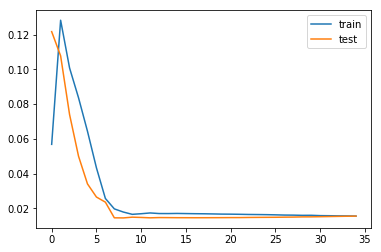

In [229]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

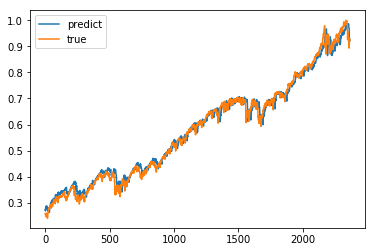

In [230]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [231]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [232]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 56.077


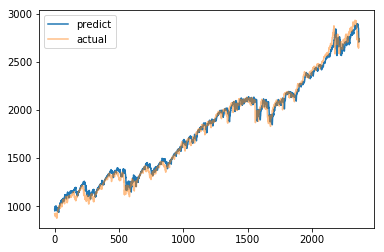

In [233]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [234]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [235]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [56]:
#sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    #print(cols)
#     # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

# Data Transformation

In [12]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [13]:
#normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [14]:
values

array([[2.78210e+02, 8.05000e+00, 8.92000e+00, ..., 1.38200e+00,
        1.39780e+02, 5.94200e-01],
       [2.80170e+02, 8.06000e+00, 8.87000e+00, ..., 1.38640e+00,
        1.40450e+02, 5.95600e-01],
       [2.82160e+02, 7.97000e+00, 8.78000e+00, ..., 1.38830e+00,
        1.40600e+02, 5.97700e-01],
       ...,
       [2.71174e+03, 2.87000e+00, 3.15000e+00, ..., 1.41040e+00,
        1.12860e+02, 7.82500e-01],
       [2.74037e+03, 2.84000e+00, 3.14000e+00, ..., 1.39100e+00,
        1.12790e+02, 7.70800e-01],
       [2.72306e+03, 2.91000e+00, 3.22000e+00, ..., 1.38910e+00,
        1.13090e+02, 7.71300e-01]], dtype=float32)

In [15]:
#convert data to become supervised 
look_back = 3 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed
#t-1 is the current period (closest historic data)
#t is the first predicted period

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,278.209991,8.05,8.92,18.629999,475.250000,1.3820,139.779999,0.5942,280.170013,8.06,...,140.600006,0.5977,289.109985,7.79,8.55,18.629999,449.000000,1.4029,143.300003,0.6120
4,280.170013,8.06,8.87,18.450001,469.100006,1.3864,140.449997,0.5956,282.160004,7.97,...,143.300003,0.6120,288.730011,7.84,8.60,18.600000,449.500000,1.3988,143.520004,0.6200
5,282.160004,7.97,8.78,18.549999,466.500000,1.3883,140.600006,0.5977,289.109985,7.79,...,143.520004,0.6200,290.760010,7.81,8.56,18.600000,453.100006,1.4041,143.399994,0.6152
6,289.109985,7.79,8.55,18.629999,449.000000,1.4029,143.300003,0.6120,288.730011,7.84,...,143.399994,0.6152,290.100006,7.69,8.49,18.580000,451.000000,1.4041,144.100006,0.6137
7,288.730011,7.84,8.60,18.600000,449.500000,1.3988,143.520004,0.6200,290.760010,7.81,...,144.100006,0.6137,289.829987,7.67,8.45,18.650000,442.899994,1.3992,145.449997,0.6157
8,290.760010,7.81,8.56,18.600000,453.100006,1.4041,143.399994,0.6152,290.100006,7.69,...,145.449997,0.6157,288.459991,7.85,8.72,18.680000,455.000000,1.3982,142.250000,0.6085
9,290.100006,7.69,8.49,18.580000,451.000000,1.4041,144.100006,0.6137,289.829987,7.67,...,142.250000,0.6085,293.470001,7.78,8.64,18.750000,453.000000,1.3951,142.800003,0.6086
10,289.829987,7.67,8.45,18.650000,442.899994,1.3992,145.449997,0.6157,288.459991,7.85,...,142.800003,0.6086,295.089996,7.76,8.58,18.780001,452.750000,1.4006,144.300003,0.6161
11,288.459991,7.85,8.72,18.680000,455.000000,1.3982,142.250000,0.6085,293.470001,7.78,...,144.300003,0.6161,293.450012,7.66,8.50,18.650000,453.500000,1.4008,143.800003,0.6131
12,293.470001,7.78,8.64,18.750000,453.000000,1.3951,142.800003,0.6086,295.089996,7.76,...,143.800003,0.6131,296.720001,7.68,8.53,18.750000,456.549988,1.4006,143.449997,0.6103


In [16]:
#look_back = 5
number_of_variables = 8
#keeping first varible in first period
reframed.drop(reframed.columns[-1 * number_of_variables + 1:], axis=1, inplace=True) 
#print(reframed.head())

reframed.drop(reframed.columns[look_back*number_of_variables:-1], axis=1, inplace=True)
#print(reframed.head())

In [17]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
3,278.209991,8.05,8.92,18.629999,475.250000,1.3820,139.779999,0.5942,280.170013,8.06,...,0.5956,282.160004,7.97,8.78,18.549999,466.500000,1.3883,140.600006,0.5977,289.109985
4,280.170013,8.06,8.87,18.450001,469.100006,1.3864,140.449997,0.5956,282.160004,7.97,...,0.5977,289.109985,7.79,8.55,18.629999,449.000000,1.4029,143.300003,0.6120,288.730011
5,282.160004,7.97,8.78,18.549999,466.500000,1.3883,140.600006,0.5977,289.109985,7.79,...,0.6120,288.730011,7.84,8.60,18.600000,449.500000,1.3988,143.520004,0.6200,290.760010
6,289.109985,7.79,8.55,18.629999,449.000000,1.4029,143.300003,0.6120,288.730011,7.84,...,0.6200,290.760010,7.81,8.56,18.600000,453.100006,1.4041,143.399994,0.6152,290.100006
7,288.730011,7.84,8.60,18.600000,449.500000,1.3988,143.520004,0.6200,290.760010,7.81,...,0.6152,290.100006,7.69,8.49,18.580000,451.000000,1.4041,144.100006,0.6137,289.829987
8,290.760010,7.81,8.56,18.600000,453.100006,1.4041,143.399994,0.6152,290.100006,7.69,...,0.6137,289.829987,7.67,8.45,18.650000,442.899994,1.3992,145.449997,0.6157,288.459991
9,290.100006,7.69,8.49,18.580000,451.000000,1.4041,144.100006,0.6137,289.829987,7.67,...,0.6157,288.459991,7.85,8.72,18.680000,455.000000,1.3982,142.250000,0.6085,293.470001
10,289.829987,7.67,8.45,18.650000,442.899994,1.3992,145.449997,0.6157,288.459991,7.85,...,0.6085,293.470001,7.78,8.64,18.750000,453.000000,1.3951,142.800003,0.6086,295.089996
11,288.459991,7.85,8.72,18.680000,455.000000,1.3982,142.250000,0.6085,293.470001,7.78,...,0.6086,295.089996,7.76,8.58,18.780001,452.750000,1.4006,144.300003,0.6161,293.450012
12,293.470001,7.78,8.64,18.750000,453.000000,1.3951,142.800003,0.6086,295.089996,7.76,...,0.6161,293.450012,7.66,8.50,18.650000,453.500000,1.4008,143.800003,0.6131,296.720001


In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [19]:
scaled

array([[0.02005667, 0.80840165, 0.85214452, ..., 0.77072951, 0.35258961,
        0.02408352],
       [0.02078077, 0.80942627, 0.84650116, ..., 0.80280361, 0.39328394,
        0.02394314],
       [0.02151595, 0.80020489, 0.83634313, ..., 0.80541707, 0.41605007,
        0.0246931 ],
       ...,
       [0.89949127, 0.27151639, 0.19300226, ..., 0.44000955, 0.88702325,
        0.91908985],
       [0.89304833, 0.27151639, 0.19300226, ..., 0.44119747, 0.87848608,
        0.92966685],
       [0.90833554, 0.27459015, 0.19751693, ..., 0.44036592, 0.8451906 ,
        0.92327189]])

In [20]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [26]:
# test = scaled[-1,:]
# test = test[:,-1]
# test = test.reshape((test.shape[0],1,test.shape[1]))
# test.shape

IndexError: too many indices for array

In [18]:
# test

array([0.90833554, 0.27459015, 0.19751693, 0.49373379, 0.59225431,
       0.42871868, 0.44000955, 0.88702325, 0.91908985, 0.27766392,
       0.20090296, 0.48750462, 0.58589085, 0.43241157, 0.44119747,
       0.87848608, 0.92966685, 0.27459015, 0.19977429, 0.46088247,
       0.59575571, 0.41575062, 0.44036592, 0.8451906 , 0.92327189])

In [21]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [32]:
#train_X

In [33]:
#train_y

In [24]:
train_X.shape

(5549, 24)

In [26]:
#reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 3, 8))
test_X = test_X.reshape((test_X.shape[0], 3, 8))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5549, 3, 8) (5549,) (2379, 3, 8) (2379,)


# Final Input Data Example

In [27]:
test_X

array([[[0.24545687, 0.07479508, 0.2234763 , ..., 0.33029884,
         0.22867667, 0.45702902],
        [0.24496551, 0.07786885, 0.234763  , ..., 0.31475433,
         0.22249937, 0.44223099],
        [0.25358446, 0.08196721, 0.24040633, ..., 0.31630025,
         0.22677593, 0.43710862]],

       [[0.24496551, 0.07786885, 0.234763  , ..., 0.31475433,
         0.22249937, 0.44223099],
        [0.25358446, 0.08196721, 0.24040633, ..., 0.31630025,
         0.22677593, 0.43710862],
        [0.24720429, 0.08196721, 0.26410837, ..., 0.3118344 ,
         0.22915185, 0.42287984]],

       [[0.25358446, 0.08196721, 0.24040633, ..., 0.31630025,
         0.22677593, 0.43710862],
        [0.24720429, 0.08196721, 0.26410837, ..., 0.3118344 ,
         0.22915185, 0.42287984],
        [0.25229143, 0.08299181, 0.2595937 , ..., 0.3136379 ,
         0.24994064, 0.4351166 ]],

       ...,

       [[0.89949127, 0.27151639, 0.19300226, ..., 0.43275504,
         0.42682351, 0.87051782],
        [0.89304833, 

# Model 2

In [31]:
model = Sequential()

model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=50))
model.add(Dropout(0.2))
#model.add(LSTM(units=100, return_sequences=True))
#model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(
    250,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation("linear"))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 50)             11800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 250)               301000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 313,051
Trainable params: 313,051
Non-trainable params: 0
_________________________________________________________________


In [32]:
n_batch = 150#len(train_X)
history = model.fit(train_X, train_y, epochs=100, batch_size=n_batch, validation_data=(test_X, test_y))

Train on 5549 samples, validate on 2379 samples
Epoch 1/100
5549/5549 [==============================] - 3s 533us/step - loss: 0.0177 - val_loss: 0.0161
Epoch 2/100
5549/5549 [==============================] - 1s 159us/step - loss: 0.0024 - val_loss: 0.0266
Epoch 3/100
5549/5549 [==============================] - 1s 163us/step - loss: 8.4958e-04 - val_loss: 0.0206
Epoch 4/100
5549/5549 [==============================] - 1s 162us/step - loss: 6.3151e-04 - val_loss: 0.0110
Epoch 5/100
5549/5549 [==============================] - 1s 163us/step - loss: 4.9410e-04 - val_loss: 0.0058
Epoch 6/100
5549/5549 [==============================] - 1s 162us/step - loss: 4.5087e-04 - val_loss: 0.0041
Epoch 7/100
5549/5549 [==============================] - 1s 162us/step - loss: 4.0651e-04 - val_loss: 0.0023
Epoch 8/100
5549/5549 [==============================] - 1s 164us/step - loss: 3.7401e-04 - val_loss: 0.0021
Epoch 9/100
5549/5549 [==============================] - 1s 161us/step - loss: 3.5972e-0

Epoch 73/100
5549/5549 [==============================] - 1s 155us/step - loss: 1.4695e-04 - val_loss: 2.8810e-04
Epoch 74/100
5549/5549 [==============================] - 1s 154us/step - loss: 1.5447e-04 - val_loss: 3.0589e-04
Epoch 75/100
5549/5549 [==============================] - 1s 154us/step - loss: 1.4405e-04 - val_loss: 5.2438e-04
Epoch 76/100
5549/5549 [==============================] - 1s 154us/step - loss: 1.4096e-04 - val_loss: 3.4431e-04
Epoch 77/100
5549/5549 [==============================] - 1s 159us/step - loss: 1.3971e-04 - val_loss: 5.4274e-04
Epoch 78/100
5549/5549 [==============================] - 1s 162us/step - loss: 1.4952e-04 - val_loss: 5.9157e-04
Epoch 79/100
5549/5549 [==============================] - 1s 161us/step - loss: 1.5142e-04 - val_loss: 6.1023e-04
Epoch 80/100
5549/5549 [==============================] - 1s 167us/step - loss: 1.4351e-04 - val_loss: 7.9009e-04
Epoch 81/100
5549/5549 [==============================] - 1s 157us/step - loss: 1.5213e-

In [ ]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')

# Callbacks
from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('market_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]


multi_history = multi_model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), 
                                verbose=1, shuffle=False, callbacks = callbacks_list)

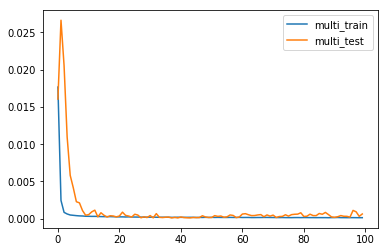

In [33]:
#plot result 
multi_history = history
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [24]:
s_save.shape

(25,)

In [23]:
test_X.shape

(2379, 1, 24)

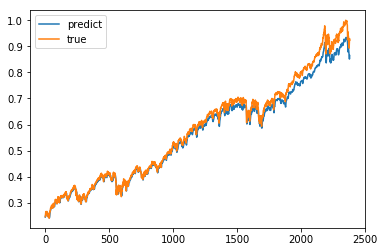

In [34]:
#plot prediction
from keras.models import load_model

#multi_model = load_model("market_lstm_model_weights.hdf5")
yhat = model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [35]:
test_X.shape

(2379, 3, 8)

# Invert Prediction Results

In [36]:
# invert scaling for prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
test_X[:, :-1]

array([[0.24545687, 0.07479508, 0.2234763 , ..., 0.42150773, 0.31630025,
        0.22677593],
       [0.24496551, 0.07786885, 0.234763  , ..., 0.42516137, 0.3118344 ,
        0.22915185],
       [0.25358446, 0.08196721, 0.24040633, ..., 0.42927171, 0.3136379 ,
        0.24994064],
       ...,
       [0.89949127, 0.27151639, 0.19300226, ..., 0.59225431, 0.42871868,
        0.44000955],
       [0.89304833, 0.27151639, 0.19300226, ..., 0.58589085, 0.43241157,
        0.44119747],
       [0.90833554, 0.27459015, 0.19751693, ..., 0.59575571, 0.41575062,
        0.44036592]])

In [37]:
test_X.shape

(2379, 24)

In [48]:
yhat

array([[0.24539216],
       [0.24705227],
       [0.2503755 ],
       ...,
       [0.8510711 ],
       [0.8535246 ],
       [0.8644726 ]], dtype=float32)

In [38]:
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

In [39]:
inv_yhat.shape

(2379, 25)

In [40]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat.shape
inv_yhat = inv_yhat[:,-1]

In [45]:
test_y

array([0.24720429, 0.25229143, 0.25683919, ..., 0.91908985, 0.92966685,
       0.92327189])

In [44]:
test_X.shape

(2379, 24)

In [49]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# inv_y
# inv_yhat

#inv_y

In [51]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.025


In [52]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 67.992


In [150]:
#len(inv_y)

In [151]:
#print(pd.DataFrame(inv_y))

In [152]:
#data.tail(len(inv_y)).index

In [53]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
#predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
#py.iplot([predict_chart, multi_predict_chart, actual_chart])
py.iplot([multi_predict_chart, actual_chart])